<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.955 · Models avançats de mineria de dades · PAC2</p>
<p style="margin: 0; text-align:right;">2020-2 · Màster universitari en Ciència de dades (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudis d'Informàtica, Multimèdia i Telecomunicacions</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# PAC 2: Mètodes no supervisats

Al llarg d'aquesta pràctica veurem com aplicar diferents tècniques no supervisades, així com algunes de les seves aplicacions reals:

 - **Clustering amb diferents estratègies**: k-means i regla del colze, basades en densitat i jeràrquiques.
 - **Optimizació amb reducció de dimensionalitat**: t-SNE.
 - **Aplicació**: identificació de punts d'interès turístics.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Nom i cognoms:</strong>
</div>

Jordi Montserrat

---

Per realitzar aquesta pràctica, necessitarem les següents llibreries:

In [1]:
import random

import numpy as np
import pandas as pd
import sklearn
from sklearn import preprocessing
from sklearn import cluster                   # Algorismes de clustering.
from sklearn import datasets                  # Crear datasets.
from sklearn import manifold                  # Algorismes de reducció de dimensionalitat.
from sklearn import neighbors
from sklearn import decomposition             # Mòdul de reducció de dimensionalitat.
from sklearn.utils import check_random_state  # Gestió de números aleatoris.

# Clustering jeràrquic i dendrograma.
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# UMAP per la reducció de dimensionalitat.
import umap

# Visualització.
import matplotlib
import matplotlib.pyplot as plt

# !pip install opencv-python
import cv2

%matplotlib inline

## 1. Mètodes de *clustering* (4 punts)

Aquest exercici tracta d'explorar diferents tècniques d'agrupament ajustant-les a diferents conjunts de dades.

L'objectiu és doble: entendre l'influència dels paràmetres en el seu comportament, i coneixer les seves limitacions en la recerca d'estructures de dades.

### Generació dels conjunts de dades

In [2]:
X_blobs, y_blobs = datasets.make_blobs(n_samples=1000, n_features=2, centers=4, cluster_std=1.6, random_state=42)
X_moons, y_moons = datasets.make_moons(n_samples=1000, noise=.07, random_state=42)
X_circles, y_circles = datasets.make_circles(n_samples=1000, factor=.5, noise=.05, random_state=42)

Cada dataset té 2 variables: una variable *X* que conté dues features (columnes) i tantes files com mostres. I una variable *y* que conté les etiquetes que identificaran cada cluster.

Al llarg de l'exercici no s'utilitzarà la variable *y* (només amb l'objectiu de visualtizar). L'objectiu és, mitjançant els diferents models de *clustering*, aconseguir trobar les estructures descrites per les variables *y*.

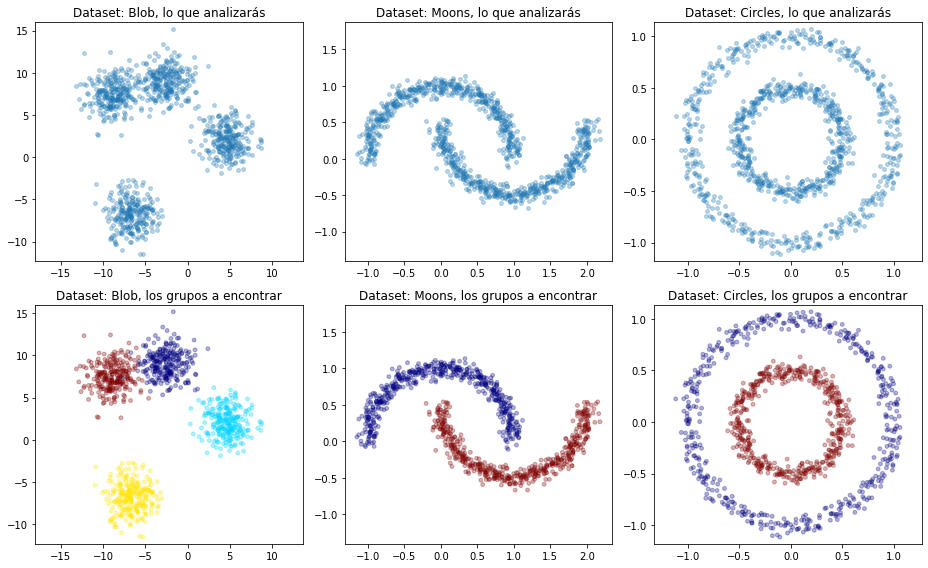

In [3]:
fig, axis = plt.subplots(2, 3, figsize=(13, 8))
for i, (X, y, ax, name) in enumerate(zip([X_blobs, X_moons, X_circles] * 2,
                                         [None] * 3 + [y_blobs, y_moons, y_circles],
                                         axis.reshape(-1),
                                         ['Blob', 'Moons', 'Circles'] * 2)):
    ax.set_title('Dataset: {}, '.format(name) + ('lo que analizarás' if i < 3 else 'los grupos a encontrar'))
    ax.scatter(X[:,0], X[:,1], s=15, c=y, alpha=.3, cmap='jet')
    ax.axis('equal')
plt.tight_layout()

### 1 a. K-means

En aquest apartat es demana provar l'algorisme *k-means* sobre els tres datasets presentats anteriorment ajustant amb els paràmetres adecuats i analitzar-ne els resultats.

In [4]:
X, y = X_blobs, y_blobs

In [5]:
print(X.shape, y.shape)
print("dtype:", X.dtype)
print("dtype y", y.dtype)

(1000, 2) (1000,)
dtype: float64
dtype y int64


Es demana estimar el nombre de clústers a detectar per *k-means*. Una tècnica per estimar $k$ és, com s'explica a la teoria:
> Els criteris anteriors (minimització de distàncies intra grup o maximització de distàncies inter grup) poden usar-se per establir un valor adequat per al paràmetre k. Valors k per als quals ja no s'aconsegueixen millores significatives en l'homogeneïtat interna dels segments o l'heterogeneïtat entre segments diferents, haurien de descartar-se.

El que popularment es coneix com *regla del colze*.

Primer cal calcular la suma dels errors quadràtics ([*SSE*](https://bl.ocks.org/rpgove/0060ff3b656618e9136b)) que consisteix en la suma de tots els errors (distància de cada punt al seu centroide assignat) al quadrat.

$$SSE = \sum_{i=1}^{K} \sum_{x \in C_i} euclidean(x, c_i)^2$$

On $K$ és el nombre de clústers a buscar per *k-means*, $x \in C_i$ són els punts que pertanyen a l'i-èsim clúster, $c_i $ és el centroide del clúster $C_i$ (al que pertany el punt $x$), i $euclidean$ és la [distància euclidiana](https://en.wikipedia.org/wiki/Euclidean_distance).

Aquest procediment realitzat per a cada possible valor $k$, resulta en una funció monòtona decreixent on l'eix $x$ representa els diferents valors de $k$, i l'eix $i$ el $SSE$. Intuïtivament es podrà observar un significatiu descens de l'error, que indicarà el valor idoni de $ k $.

**Es demana realitzar la representació gràfica de la regla del colze amb la seva interpretació, utilitzant la llibreria `` `matplotlib``` i la implementació en scikit-learn de [*k-means*](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html).**

In [6]:
def elbow_method(X, start_k, end_k):
    distortions = []
    K = range(start_k, end_k)
    for k in K:
        kmeanModel = cluster.KMeans(n_clusters=k)
        kmeanModel.fit(X)
        distortions.append(kmeanModel.inertia_)
    return distortions, K

def visualize_elbow_method(K, distortions):
    plt.figure(figsize=(16,8))
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()

In [7]:
def prepare_kmeans(X, y, n_clusters):
    df = pd.DataFrame(X)
    kmeanModel = cluster.KMeans(n_clusters=n_clusters)
    kmeanModel.fit(X)
    df['k_means']=kmeanModel.predict(X)
    df['target']=y
    return df

def visualize_kmeans(df):
    fig, axes = plt.subplots(1, 2, figsize=(16,8))
    axes[0].scatter(df[0], df[1], c=df['target'])
    axes[1].scatter(df[0], df[1], c=df['k_means'], cmap=plt.cm.Set1)
    axes[0].set_title('Actual', fontsize=18)
    axes[1].set_title('K_Means', fontsize=18)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> cálcul i visualizació de la regla del colze en el dataset Blobs.
</div>

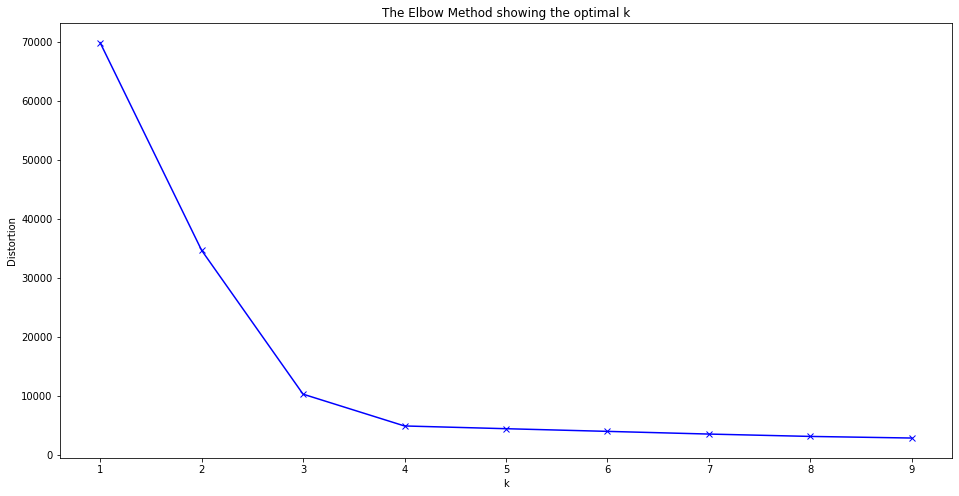

In [8]:
elbow_blobs, elbow_range = elbow_method(X, 1, 10)
visualize_elbow_method(elbow_range, elbow_blobs)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Anàlisis:</strong> Què s'interpreta a la gràfica? Com podria millorar-se l'elecció de $k$?.  
</div>

S'observa que el nombre óptim de grups es 4 que es relaciona amb els nivells de la variable resposta y. Un métode per millorar la selecció de k es repetir diverses vegades el procediment. La rao es que al inicialitzar de forma aleatória el centroide de cada un dels grups es pot observar canvis en la distribució de les classes.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> cálcul i visualizació dels grups en el dataset Blobs.
</div>

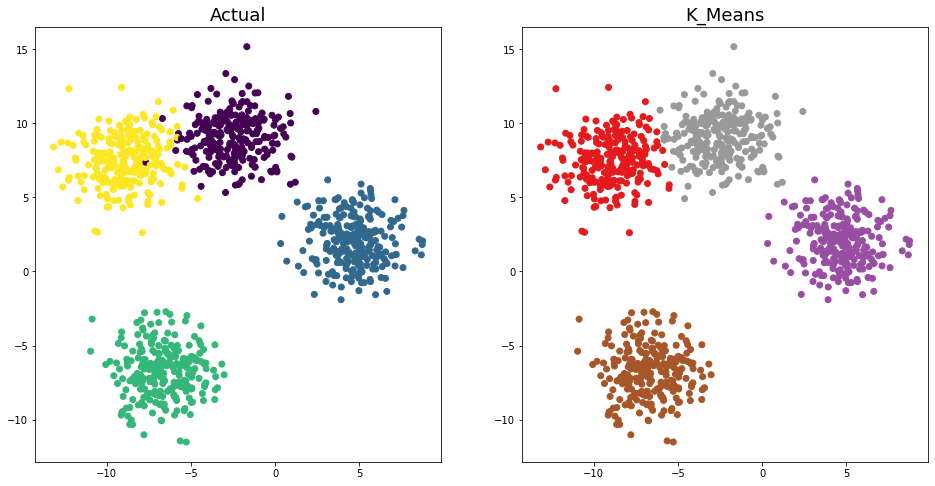

In [9]:
df_blobs = prepare_kmeans(X, y, n_clusters=4)
visualize_kmeans(df_blobs)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Anàlisis:</strong> Qué ha passat? Explica els motiuss pels que creus que s'ha obtingut aquest resultat.
</div>

El métode Kmeans ha pogut separar de forma exacta els cuatre grups tal com mostra la variable resposta.
La raó principal es que, en aquest cas, la distància entre els grups es clara i, fent servir la suma del cuadrat dels errors es pot obtenir una noció forma acurada de les diferents classes visibles en la varible resposta. També es important tenir present la forma del núvol de punts, factor que facilita al algorítme Kmeans de trobar els diferents clusters o grups.

In [10]:
X, y = X_moons, y_moons

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> cálcul i visualizació de la regla del colze en el dataset Moons.
</div>

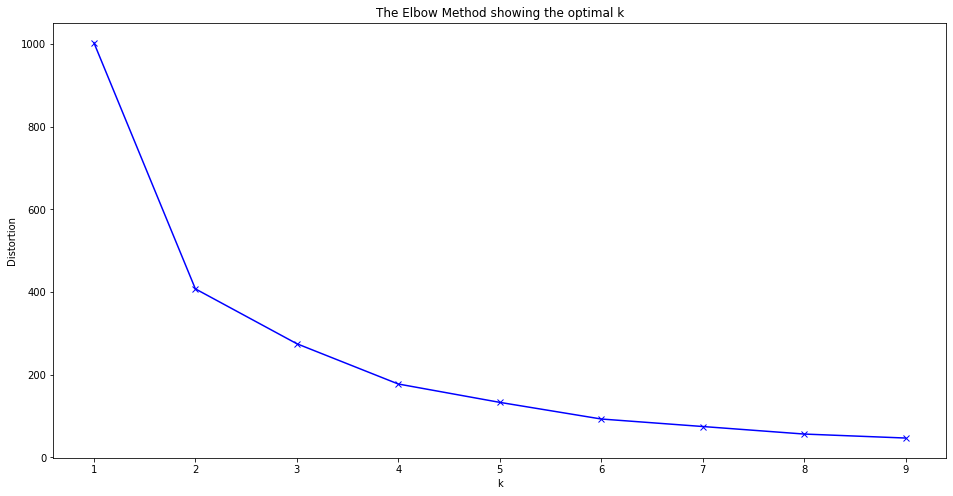

In [11]:
elbow_blobs, elbow_range = elbow_method(X, 1, 10)
visualize_elbow_method(elbow_range, elbow_blobs)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Anàlisis:</strong> Qué se interpreta a la gràfica? ¿Com podria millorar-se l'elecció de $k$?.  
</div>

El métode d'Elbow en aquest cas també detecta de forma eficient el nombre de grups o clusters presents a les dades en relació a la variable resposta. Tal i com s'ha comentat anteriorment es podríen correr diferents iteracions del métode Kmeans per tal d'analitzar si el fet de moure una mica el centroide porta a millors resultats. Un altre métode que es podría fer servier es el métode de la **Silueta** que, tal com el métode Elbow o del colze serveix per detectar de forma visual el nombre óptim de grups.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> cálcul i visualizació dels grups en el dataset Moons.
</div>

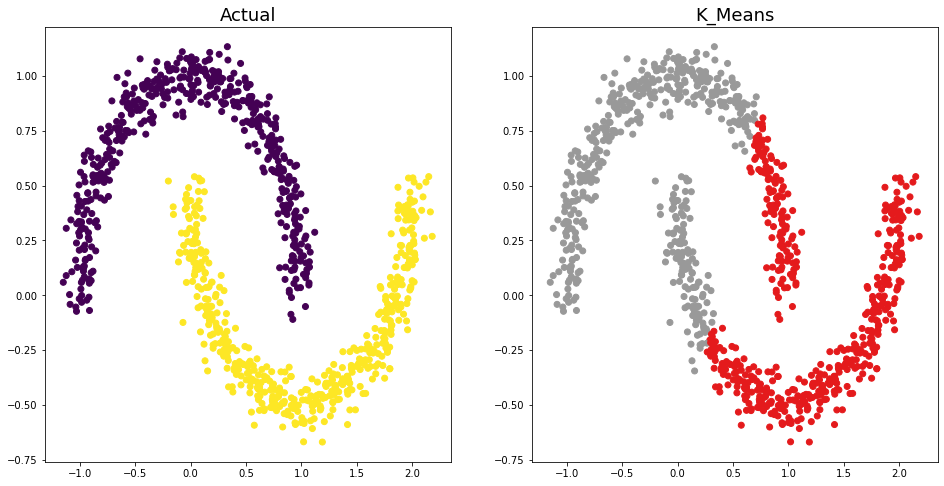

In [12]:
df_blobs = prepare_kmeans(X, y, n_clusters=2)
visualize_kmeans(df_blobs)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Anàlisis:</strong> Què ha passat? Explica els motius pels quals creus que s'ha obtingut aquest resultat. 
</div>

En aquest cas el fet de fer servir el métode Kmeans no es adecuat degut a la distribució de les dades. Per tal de millorar-ne els resultats, es podría emprar métodes **kernel** per tal de poder separa de forma eficient les dades en dos grups. Un métode adient, sería combinar Kmeans amb **SpectralClustering**. Basicament estaríem modificant l'espai dimensional del conjunt de dades per tal de fer més senzill per a Kmeans de separar les dades en els dos grups presents en la variable resposta.

In [13]:
X, y = X_circles, y_circles
X.shape

(1000, 2)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> cálcul i visualizació de la regla del colze en el dataset Circles.
</div>

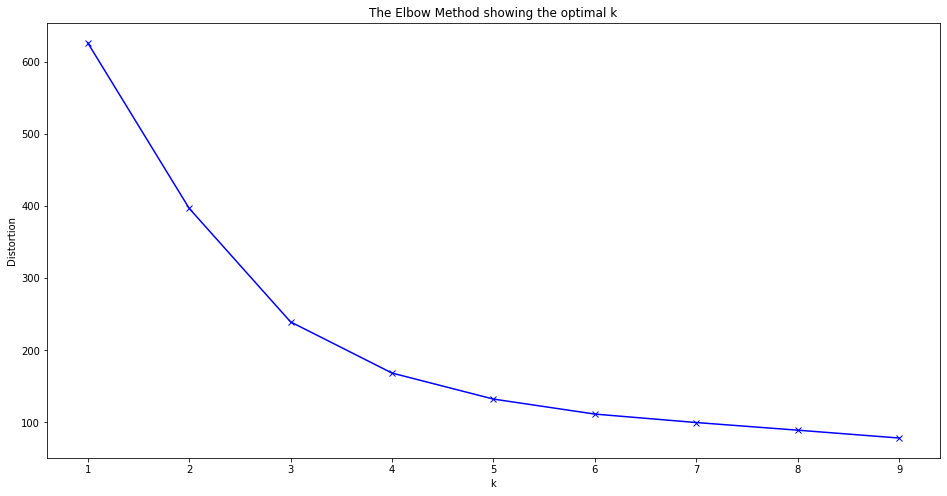

In [14]:
elbow_blobs, elbow_range = elbow_method(X, 1, 10)
visualize_elbow_method(elbow_range, elbow_blobs)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Anàlisis:</strong> Qué s'interpreta a la gráfica? Com podria millorar-se l'elecció de $k$?.  
</div>

En aquest cas, el métode Elbow indicaría un nombre de grups al voltant de 2,3 o fins i tot 4. Posiblement aquest factor es degut a la forma de la distribució de les dades en l'espai de variables.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> cálcul i visualizació dels grups en el dataset Circles.
</div>

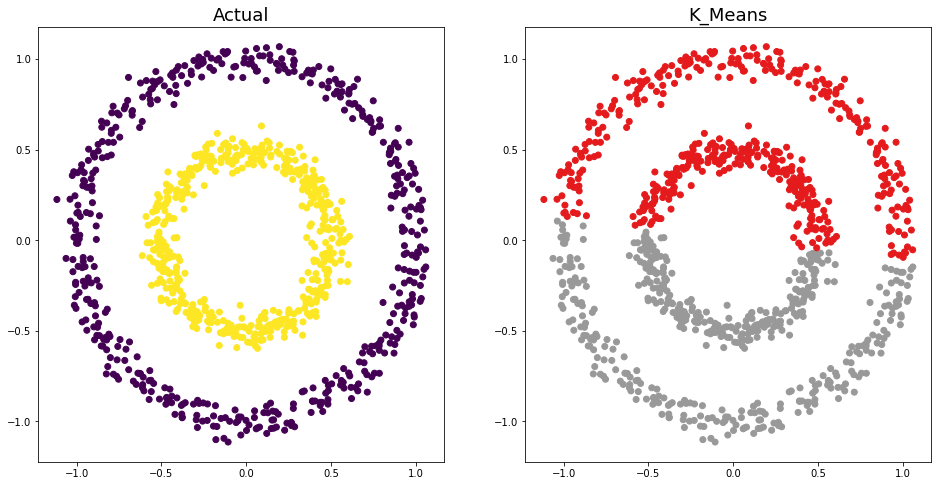

In [15]:
df_blobs = prepare_kmeans(X, y, n_clusters=2)
visualize_kmeans(df_blobs)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Anàlisis:</strong> Què ha passat? Explica els motius pels quals creus que s'ha obtingut aquest resultat.  
</div>

En aquest cas, degut a la forma geométrica present en les dades, l'algorítme Kmeans no es el métode més adient per tal de fer la separació de les dades en els dos grups que sabem que representa la variable resposta. Com s'ha esmentat en el conjunt de la pràctica, la raó principal es que aquest algorítme es eficient en conjunts de dades que presenten formes esfériques com el que s'ha vist al primer apartat amb el conjunt de dades **Blobs**.

### 1 b. Algorismes basats en densitat: DBScan

En aquest apartat es demana aplicar clustering per densitat com [DBSCAN](https://en.wikipedia.org/wiki/DBSCAN) als datasets anteriors per detectar els grups subadjacents.

Primerament parlem de com aconseguir els millors parametres per al métode DBSCAN.

Número mínim de mostres (MinPts)

Tot i que no hi ha una form automàtica per tal de determinar el valor óptim de MinPts per al DBSCAN es poden definir uns consells a l'hora de dur a terme la selecció dels valors.

Quan major sigui el conjunt de dades, major ha de ser el valor de MinPts.
Si el conjunt de dades conté un soroll elevat, cal escollir un valor més elevat de MinPts.
Com a regla general, el valor de MinPts ha de ser major o igual que la dimensionalitat del conjunt de dades. Per a dades bidimensionals es recomana fer servir un valor per defecte de 2 o 4 tot i que la regla comentada a (Sander et al., 1998) diu que es recomanable fer servir MinPts = 2*dim, on dim es igual a les dimensions del conjunt de dades.


Epsilon (ε)

Un cop s'ha determinat el valor de MinPts, es pot passar a determinar el valor Epsilon. Per tal de dur a terme la estimació, caldrá calcular la distància mitjana entre cada punt i els seus k veins més propers, on k es igual al valor de MinPts que s'ha seleccionat. A continuació, les distàncies k mitjanes es representen en ordre ascendent en un gràfic. El punt a escollir es aquell de màxima curvatura, es a dir, on el gràfic presenta major pendent.

In [16]:
colors = ['royalblue', 'maroon', 'forestgreen', 'mediumorchid', 'tan', 'deeppink', 'olive', 'goldenrod', 'lightcyan', 'navy']
vectorizer = np.vectorize(lambda x: colors[x % len(colors)])

def get_eps(X, min_samples):
    neigh = neighbors.NearestNeighbors(n_neighbors=min_samples)
    nbrs = neigh.fit(X)
    distances, indices = nbrs.kneighbors(X)
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    plt.plot(distances)

def dbscan_clustering(X, eps, min_samples):
    m = cluster.DBSCAN(eps=eps, min_samples=min_samples)
    m.fit(X)
    clusters = m.labels_
    # plot the cluster assignments
    plt.scatter(X[:, 0], X[:, 1], c=vectorizer(clusters))
    plt.xlabel("Feature 0")
    plt.ylabel("Feature 1")

In [17]:
X, y = X_blobs, y_blobs

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> prova la implementació de <a href="http://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html">DBSCAN en scikit-learn</a> jugant amb els paràmetros <i>eps</i> i <i>min_samples</i> per trobar els grups (i <i>outliers</i>) del dataset Blobs.
</div>

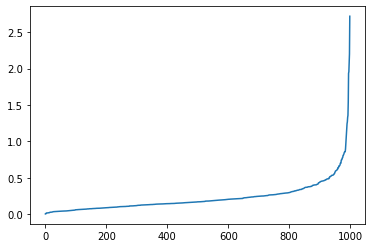

In [18]:
get_eps(X, min_samples=8) # With 2 or 4 min eps the value of eps is around 0.5

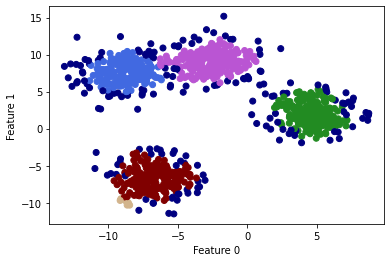

In [19]:
dbscan_clustering(X, eps=0.7, min_samples=8)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Anàlisis:</strong> Què ha passat? Explica els motius pels quals creus que s'ha obtingut aquest resultat.  
</div>

Es pot observar com els resultats coincideixen amb la separació observada en la variable resposta. Tot i això, es pot observar soroll en la visualització dels resultats fet que ens pot indicar que caldría tunejar una mica més els parametres (principalment el valor de epsilon). Degut a les formes dels núvols de punts es més senzill per el métode Kmeans de trobar la separació óptima entre els diferents grups.

In [20]:
X, y = X_moons, y_moons

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> prova la implementació de DBScan jugant amb els paràmetros <i>eps</i> i <i>min_samples</i> per trobar els grups (i <i>outliers</i>) del dataset Moons.
</div>

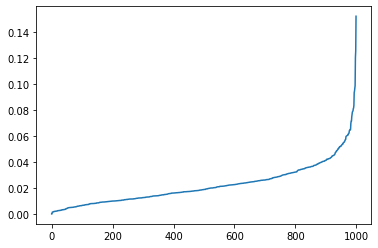

In [21]:
get_eps(X, min_samples=2) # With 2 or 4 min eps the value of eps is around 0.5

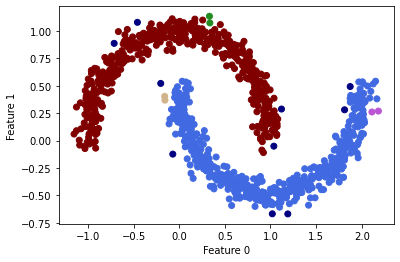

In [22]:
dbscan_clustering(X, eps=0.08, min_samples=2)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Anàlisis:</strong> Què ha passat? Explica els motius pels quals creus que s'ha obtingut aquest resultat.  
</div>

Degut a la metodología emprada per DBSCAN a l'hora de definir grups o clusters podem veure
que es capac de separar el núvol de punts en dos grups de forma eficient. Això es degut a que utilitza una técnica basada en densitat, ignorant punts de baixa densitat. Com podem veure en el gràfic, si ens basen en la densitat de punts es senzill separar els dos grups. A més, cal tenir en compte que aquest tipus de métode d'agrupació funciona bé per a grups que presenten formes irregulars, en comptes del métode Kmeans que funciona només en clusters amb forma esférica.

In [23]:
X, y = X_circles, y_circles

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> prova la implementació de DBScan jugant amb els paràmetros <i>eps</i> i <i>min_samples</i> per trobar els grups (i <i>outliers</i>) del dataset Circles.
</div>

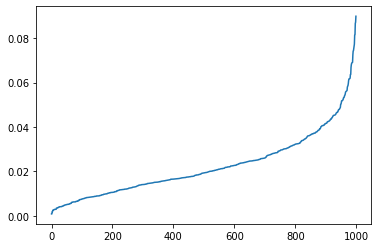

In [24]:
get_eps(X, min_samples=2) # With 2 or 4 min eps the value of eps is around 0.5

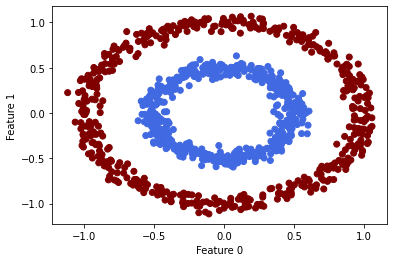

In [25]:
dbscan_clustering(X, eps=0.09, min_samples=2)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Anàlisis:</strong> Què ha passat? Explica els motius pels quals creus que s'ha obtingut aquest resultat.  
</div>

Tal i com s'ha esmentat en l'apartat anterior la metodología emprada per el métode DBSCAN permet separa de forma eficient núvols de punts que presenten aquesta forma, ja que, es senzill d'identificar els grups basant-se en densitat de punts.

### 1 c. Algorismes jeràrquics

En aquest apartat es demana visualitzar mitjançant un [dendrograma](https://en.wikipedia.org/wiki/Dendrogram) la construcció progressiva dels grups mitjançant un algorisme jeràrquic aglomeratiu (estratègia *bottom-up*). La idea és trobar un mètode gràfic per entendre el comportament de l'algorisme i trobar els *clusters* desitjats en cada dataset. 

In [26]:
# link options 'single', 'average', 'weighted', 'complete', 'centroid', 'median', 'ward'

def dendogram_scipy(X, link='single'):
    linked = linkage(X, link)
    plt.figure(figsize=(10, 7))
    dendrogram(linked,
                no_labels=True,
                orientation='top',
                distance_sort='descending',
                show_leaf_counts=True)
    plt.title(f"Dendograma amb link {link}")
    plt.show()

In [27]:
X, y = X_blobs, y_blobs

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong><br>

Prova la implementació de <a href="https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html">clustering jeràrquic de scipy</a> provant diferents <a href="https://en.wikipedia.org/wiki/Hierarchical_clustering#Linkage_criteria">criteris d'enllaç o <i>linkage</i></a> permetent identificar els clusters subadjacents (monstrant-ne el seu resultat) y el seu dendograma pel dataset Blobs.<br>
Pots importar les llibraries necessàries.
</div>

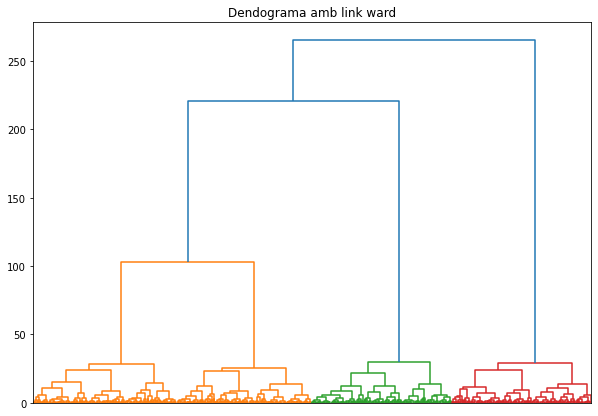

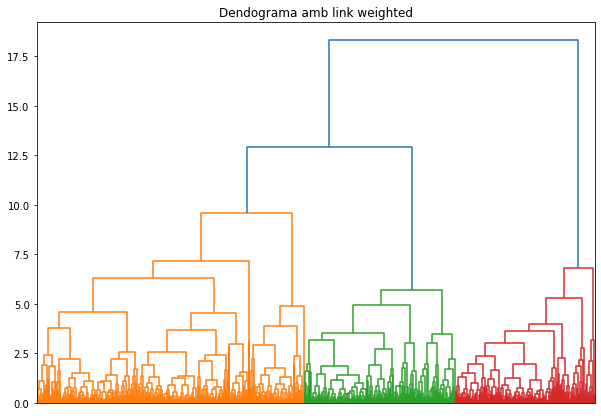

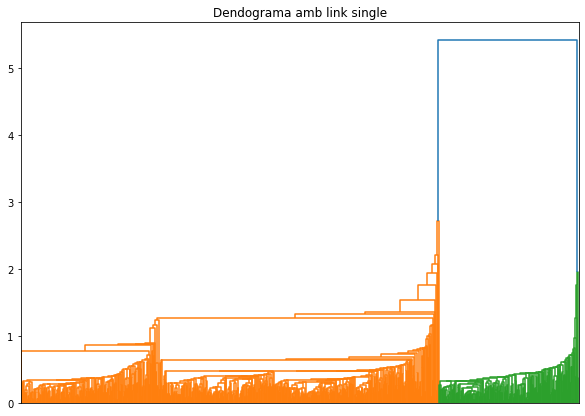

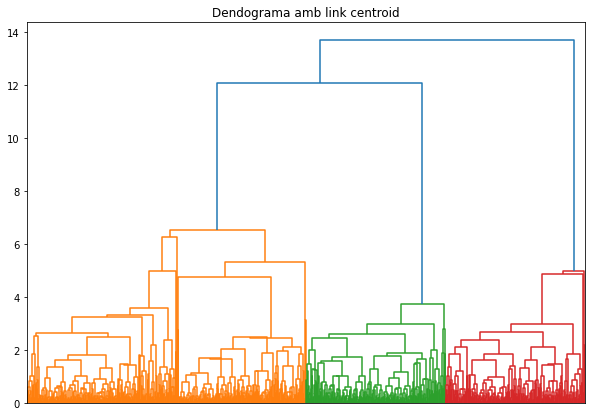

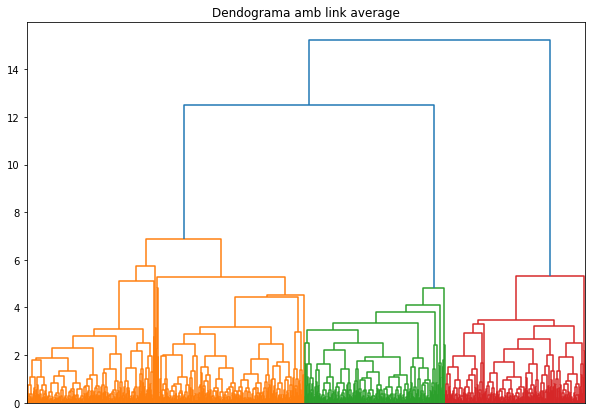

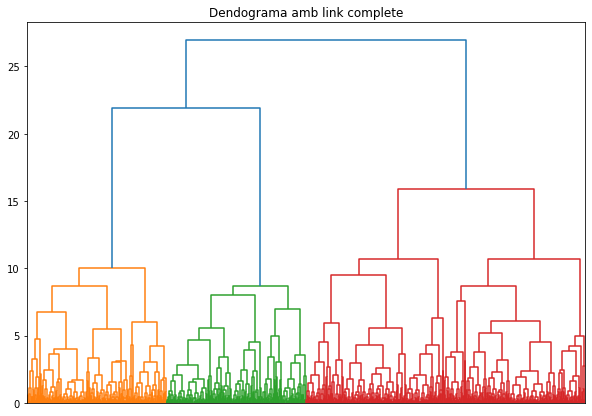

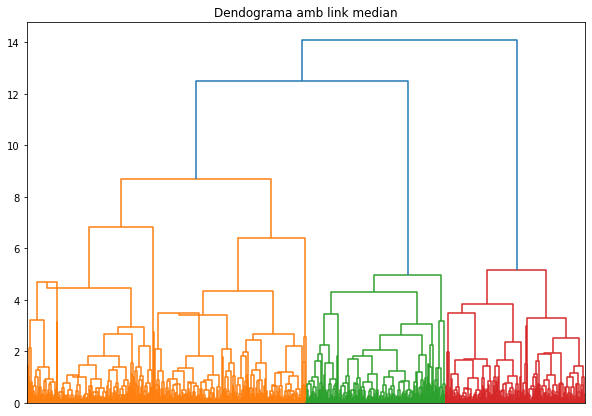

In [28]:
dendogram_scipy(X, 'ward')
dendogram_scipy(X, 'weighted')
dendogram_scipy(X, 'single')
dendogram_scipy(X, 'centroid')
dendogram_scipy(X, 'average')
dendogram_scipy(X, 'complete')
dendogram_scipy(X, 'median')

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Anàlisis:</strong> Interpreta el dendrograma i comenta quin criteri d'enllaç ha funcionat millor. Per què?
</div>

En base als resultats obtinguts, tots els métodes es decanten per definir tres grups (a part del link **single** que en detecta només dos). Es per aquest motiu que no podem dir que el dendograma sigui eficient en la detecció del nombre de clusters. Si ens haguessim de decantar per un link possiblement faríem servir 'median' o 'complete'.

In [29]:
X, y = X_moons, y_moons

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong><br>

Prova la implementació de <a href="https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html">clustering jeràrquic de scipy</a> provant diferents <a href="https://en.wikipedia.org/wiki/Hierarchical_clustering#Linkage_criteria">criteris d'enllaç o <i>linkage</i></a> permetent identificar els clusters subadjacents (monstrant-ne el seu resultat) y el seu dendograma pel dataset Moons.<br>
Pots importar les llibraries necessàries.
</div>

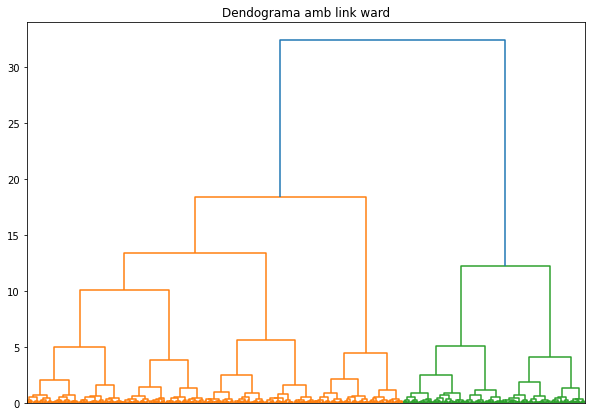

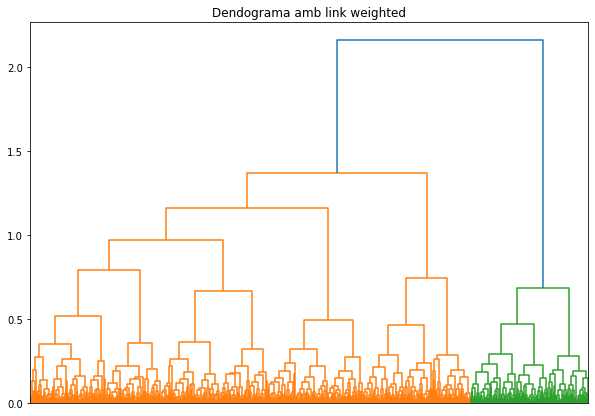

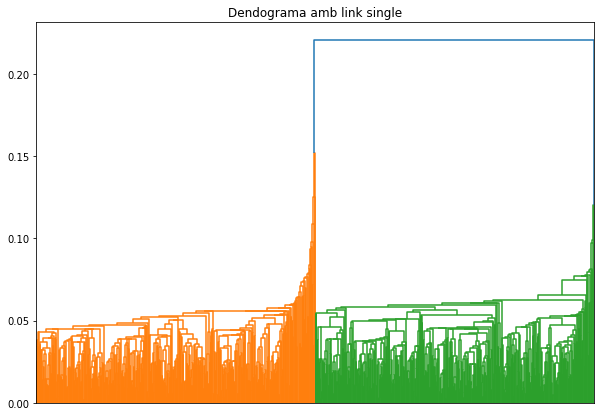

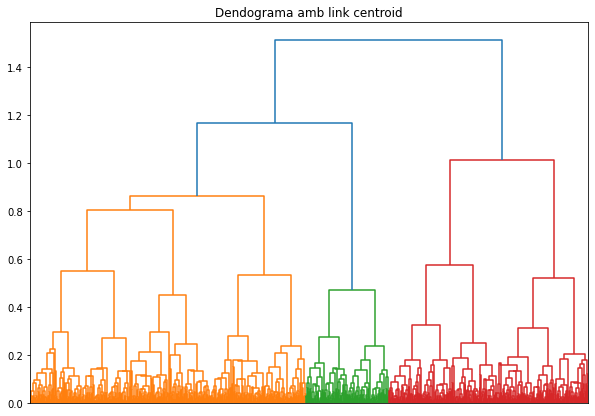

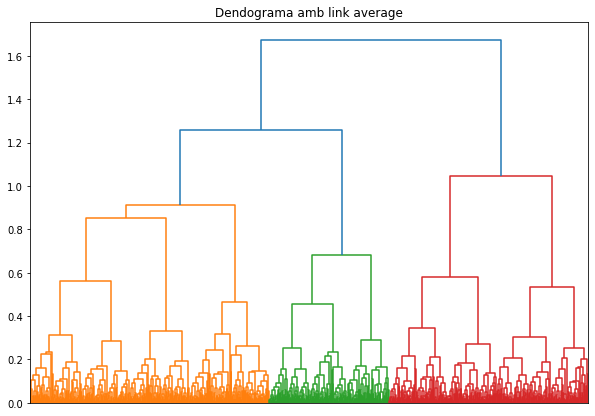

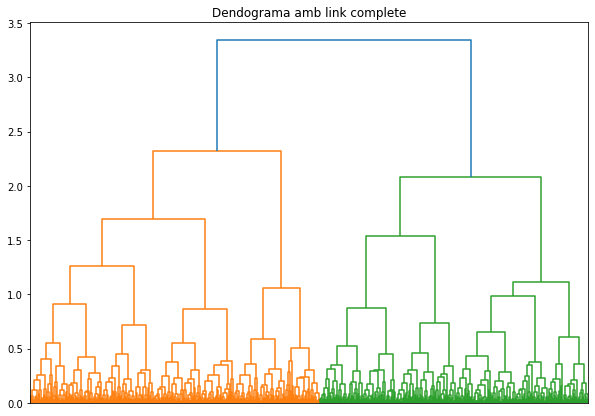

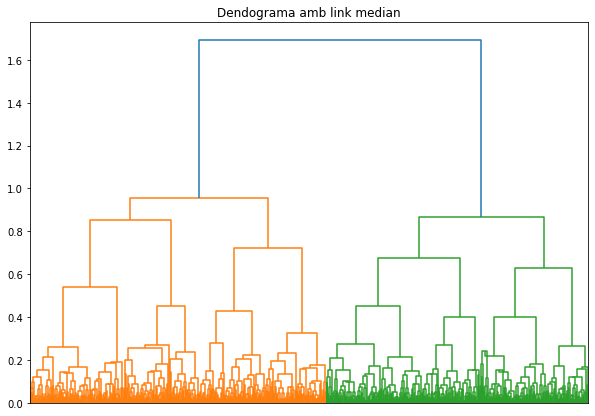

In [30]:
dendogram_scipy(X, 'ward')
dendogram_scipy(X, 'weighted')
dendogram_scipy(X, 'single')
dendogram_scipy(X, 'centroid')
dendogram_scipy(X, 'average')
dendogram_scipy(X, 'complete')
dendogram_scipy(X, 'median')

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Anàlisis:</strong> Interpreta el dendrograma i comenta quin criteri d'enllaç ha funcionat millor. Per què?
</div>

En aquest cas, sembla que diferents links permeten trobar el nombre óptim de talls en base als nivells de la variable resposta. Destacaríem 'median' i 'complete' però també 'ward', 'weighted' i 'single' en base a la forma del dendograma.

In [31]:
X, y = X_circles, y_circles

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong><br>

Prova la implementació de <a href="https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html">clustering jeràrquic de scipy</a> provant diferents <a href="https://en.wikipedia.org/wiki/Hierarchical_clustering#Linkage_criteria">criteris d'enllaç o <i>linkage</i></a> permetent identificar els clusters subadjacents (monstrant-ne el seu resultat) y el seu dendograma pel dataset Circles.<br>
Pots importar les llibraries necessàries.
</div>

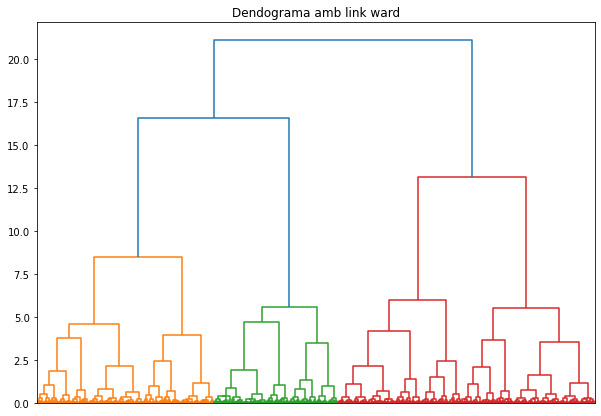

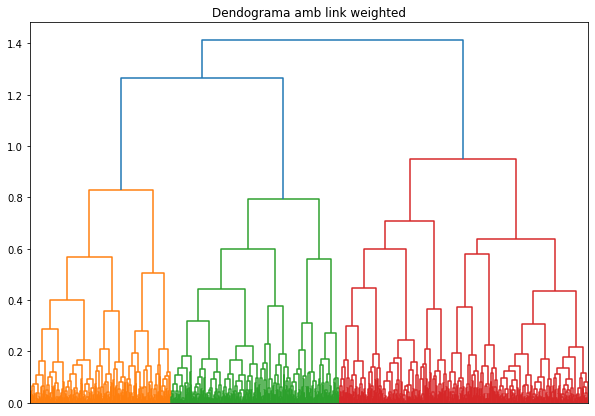

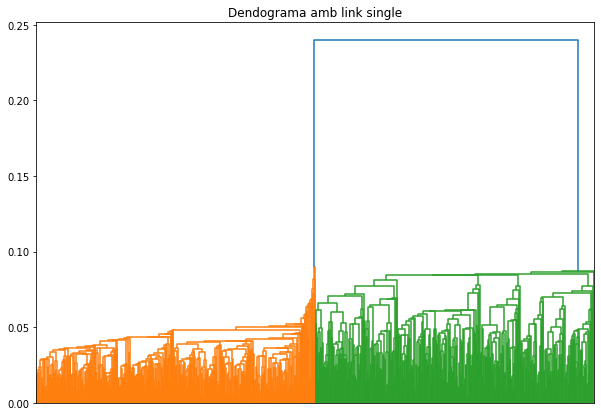

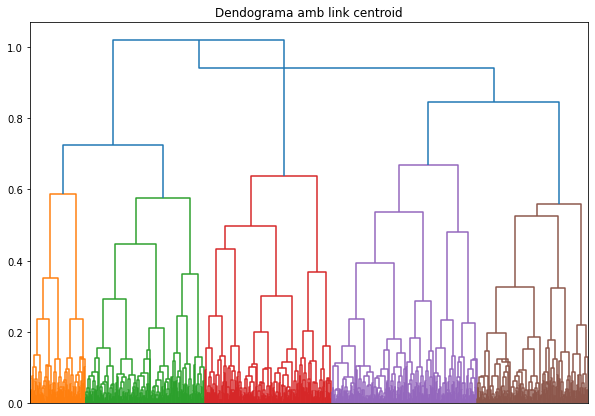

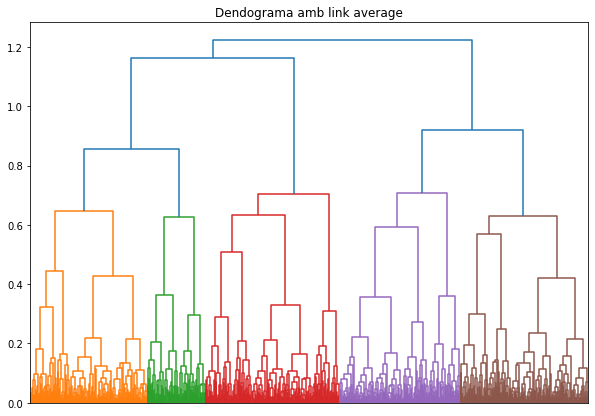

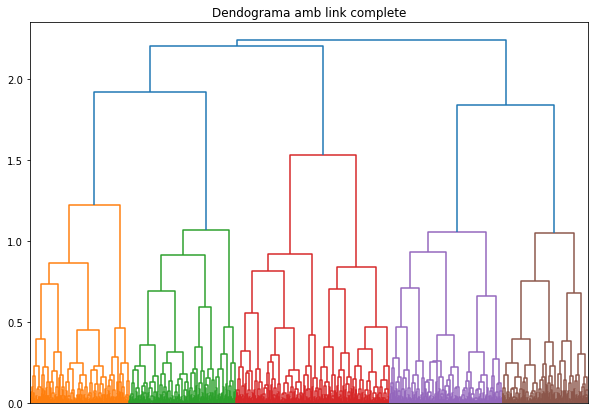

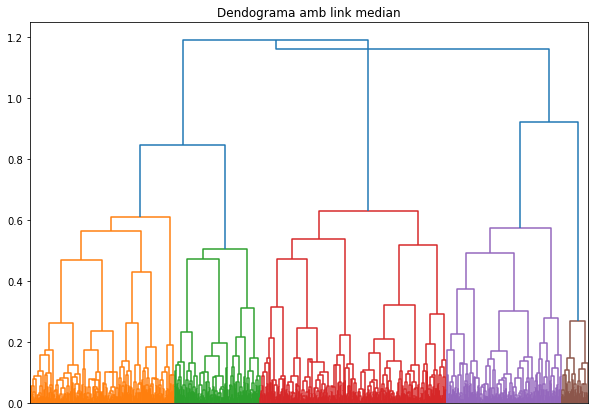

In [32]:
dendogram_scipy(X, 'ward')
dendogram_scipy(X, 'weighted')
dendogram_scipy(X, 'single')
dendogram_scipy(X, 'centroid')
dendogram_scipy(X, 'average')
dendogram_scipy(X, 'complete')
dendogram_scipy(X, 'median')

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Anàlisis:</strong> Interpreta el dendrograma i comenta quin criteri d'enllaç ha funcionat millor. Per què?
</div>

En aquest cas, només el métode 'single' ha pogut diferenciar clarament els dos grups presents en la variable resposta. La resta de métodes detecta des de 3 a 5 grups diferents.

## 2. Aplicació de reducció de dimensionalitat (2 punts)

És possible aplicar una amplia varietat d'algorismes per la reducció de dimensionalitat. Utilitzarem el dataset MNIST compost de milers de dígits manuscrits del 0 al 9. On cada imatge es composa de 784 píxels (imatges de 28 x 28), fet pel qual partim d'un nombre elevat de dimensions.

In [33]:
X, y = datasets.fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
random_state = check_random_state(0)
permutation = random_state.permutation(X.shape[0])
X = X[permutation]
y = y[permutation]
X = X.reshape((X.shape[0], -1))
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, train_size=5000, test_size=5000)
y_train = y_train.astype(int)
y_test = y_test.astype(int)

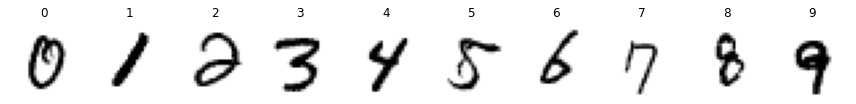

In [34]:
fig, axis = plt.subplots(1, 10, figsize=(12, 6))
for i, ax in zip(range(10), axis):
    ax.imshow(X_train[y_train == i][0].reshape(28, 28), cmap='gray_r')
    ax.set_title(str(i))
    ax.axis('off')
plt.tight_layout()

In [35]:
# PCA and UMAP functions and visualization
def scale_data(X):
    scaler = preprocessing.StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled
    
def pca_transformation(X, components=2):
    pca = decomposition.PCA(n_components=components)
    X_scaled = scale_data(X)
    pca.fit(X_scaled)
    print("Explained variance Ratio", pca.explained_variance_ratio_)
    return pca

def umap_transformation(X, n_neighbours):
    embedding = umap.UMAP(n_neighbors=n_neighbours,
                      min_dist=0.3,
                      metric='correlation')
    X_scaled = scale_data(X)
    embedding.fit(X_scaled)
    return embedding
    

def visualize_pca(projected, y):
    plt.scatter(projected[:, 0], projected[:, 1],
                c=y, edgecolor='none', alpha=0.5,
                cmap=plt.cm.get_cmap('Paired', 10))
    plt.xlabel('component 1')
    plt.ylabel('component 2')
    plt.colorbar()


In [36]:
X_train.shape # 5000 mostres amb 784 valors (pixels)
np.mean(X_train[0]), np.std(X_train[0])  # Not Scaled in Mu 0 and sd 1

(40.577806122448976, 85.1616953469726)

Si cada algorisme obté resultats diferents a l'hora de reduir la dimensionalitat, quina representació és la més fidel a la distribució original?

Abans de reduir les 784 dimensions originals de cada mostra a 2 per poder visualizar-les en 2 dimensions, és molt útil coneixer, o com a mínim intuir, l'estructura en alta dimensionalitat de les dades.

Amb aquesta finalitat es pot fer ús del dendograma com a heurística per coneixer la disposició original de les dades i comprovar si la projecció és similar al que es veu amb el dendograma.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> realitza un dendograma amb les mostres de X_train (o un subconjunt d'elles per accelerar el procés) utilitzant el mètode ward. <br>
        Com a consell, la funció dendograma té un paràmetre anomenat no_labels que evita mostrar etiquetes per a cada mostra i posat a True evita mostrar-les, carregant la imatge més de pressa.
</div>

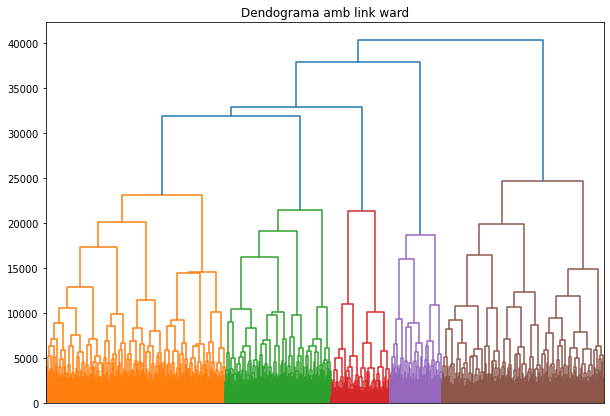

In [37]:
dendogram_scipy(X_train, 'ward')

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> apendre una projecció en 2 dimensions de les mostres de X_train amb PCA i projectar el conjunt X_test en 2 dimensions. Després visualitzar-lo en un scatter plot.<br>
    Pots utilitzar les etiquetes de y_test, el paràmetre label (quan generes el scatter) i la funció legend a la visualització per saber la classe corresponent a cada punt i interpretar el resultat de la reducció de dimensionalitat.
</div>

Explained variance Ratio [0.06095006 0.04376047]
Mean -7.39544480076839e-19 ;Std 0.9161253813129026


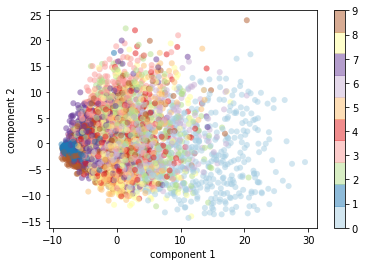

In [38]:
model = pca_transformation(X_train)
X_test_sc = scale_data(X_test)
print("Mean", np.mean(X_test_sc), ";Std", np.std(X_test_sc))
projected_test = model.transform(X_test_sc)
visualize_pca(projected_test, y_test)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Anàlisis:</strong> Què es pot intuir de la projecció? S'assembla al que s'ha representat al dendograma?
</div>

Fent servir el métode PCA (principal component analysis) no podem separar de forma clara els
diferents digits en una representació bidimensional. Això es deu a que estem fent servir un métode lineal basat en la varianca explicada. Es pot observar com hi ha diferents números que tenen una representació molt semblant (per exemple el númerp 1 amb el 9 o el 3 amb el 8). També cal tenir en compte que al projectar la varianca explicada per els dos eixos principals no podem arribar a explicar més del 10% de la varianca total.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> apendre una projecció en 2 dimensions de les mostres de X_train amb UMAP i projectar el conjunt X_test en 2 dimensions. Després visualitzar-lo en un scatter plot.<br>
    Pots utilitzar les etiquetes de y_test, el paràmetre label (quan generes el scatter) i la funció legend a la visualització per saber la classe corresponent a cada punt i interpretar el resultat de la reducció de dimensionalitat.
</div>

Mean -7.39544480076839e-19 ;Std 0.9161253813129026


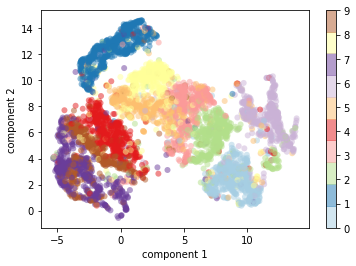

In [39]:
model_umap = umap_transformation(X_train, n_neighbours=5)
X_test_sc = scale_data(X_test)
print("Mean", np.mean(X_test_sc), ";Std", np.std(X_test_sc))
projected_test = model_umap.transform(X_test_sc)
visualize_pca(projected_test, y_test)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Anàlisis:</strong> Què es pot intuir de la projecció? S'assembla al que s'ha representat al dendograma?
</div>

Fent servier el métode UMAP (Uniform manifold approximation and projection) i atés que es un m
etode no lineal per reduir la dimensionalitat podem observar com els 9 digits es separen de forma
molt més clara que fent servir el métode del PCA.

## 3. Aplicació: segmentació d'imatges de satèlit (4 punts)

Avui en dia els mapes de carreteres, geològics, agrícoles, ... es confeccionen amb imatges de satèlits. Per poder fer això es necessita interpretar aquestes imatges buscant en elles els elements d'interès. Donat el volum actual d'imatges que generen els satèlits, fer la segmentació de forma manual no és una opció i per aquest motiu hi ha tants esforços en la seva automatització.

Assumint que l'espai de píxels té una certa estructura i que els diferents elements a buscar són grups en ella, és raonable pensar que una estratègia de clustering (entre d'altres) pot trobar aquests grups en aquesta estructura, permetent automatitzar la segmentació d'imatges.

Partim d'una imatge amb diversos tipus de vegetació i camins. 

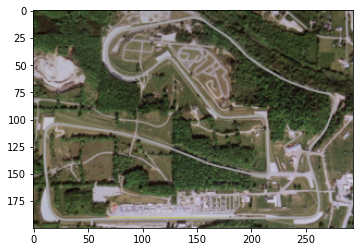

In [40]:
from skimage import io, transform

photo = transform.resize(
    io.imread('https://lh3.googleusercontent.com/-kHq0XyQh3b8/TYFk1h0r2-I/AAAAAAAAAJA/i3rdSELDqxM/s1600/road_america_base.jpg'),
    (200, 294), mode='edge')
plt.imshow(photo)
X = photo.reshape(-1, 3)

Igual que a l'apartat anterior, s'ha donat format d'array a la imatge, amb tantes files com píxels i 3 columnes (una per cada canal).

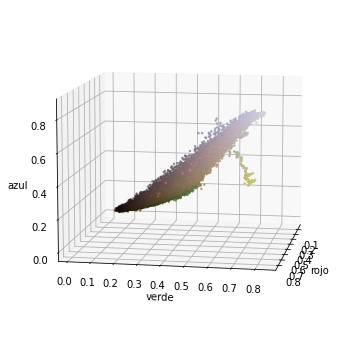

In [41]:
from mpl_toolkits.mplot3d import Axes3D

def plot_pixels_3d(data: "np.array[float]", elev: int = None, azim: int = None) -> None:
    """Visualiza pixeles en un scatter plot 3d (una por canal) con su color correspondiente.
    
    Args:
        data: np.array (puntos, 3)
        elev: int
            angulo de eleveacion en el plano z.
        azim: int
            angulo acimut en el plano x, y.
    """
    assert data.shape[1] == 3, 'Se esperaba un array bidimensional con 3 columnas: (rojo, verde y azul)'
    ax = plt.figure(figsize=(8, 6)).add_subplot(111, projection='3d')
    ax.scatter(data[:,0], data[:,1], data[:,2], s=2, c=data)
    ax.set_xlabel('rojo')
    ax.set_ylabel('verde')
    ax.set_zlabel('azul')
    ax.view_init(elev, azim)
    plt.show()

plot_pixels_3d(X, 10, 10)

In [42]:
def kmeans_color_representation(img, num_clusters):
    # Fem una copia de la imatge original abans de fer el reescalat
    img_init = img.copy()
    x, y, z = img_init.shape
    img = img.reshape((img.shape[0] * img.shape[1],img.shape[2]))
    print("Image shape", img.shape)
    # Definim el cluster amb el nombre de grups.
    clt = cluster.KMeans(n_clusters=num_clusters)
    clt.fit(img)
    label_indx = np.arange(0,len(np.unique(clt.labels_)) + 1)
    (hist, _) = np.histogram(clt.labels_, bins=label_indx)
    hist = hist.astype("float")
    hist /= hist.sum()
    hist_bar = np.zeros((50, 300, 3), dtype = "uint8") 
    # Iterem per cada un dels centroides
    startX = 0
    for (percent, color) in zip(hist,  clt.cluster_centers_): 
      endX = startX + (percent * 300) # to match grid
      cv2.rectangle(hist_bar, (int(startX), 0), (int(endX), 50),
      color.astype("uint8").tolist(), -1)
      startX = endX
    # Visualitzem la imatge original i la escala de colors obtinguda
    fig = plt.figure(figsize = (10,8))
    ax=fig.add_subplot(121)
    ax.imshow(img_init)
    ax=fig.add_subplot(122)
    ax.imshow(hist_bar)
    fig.suptitle("Imatge original i escala de color obtinguda", y=0.78)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    # Visualitzem finalment la reconstrucció de la imatge en la nova escala de color
    cluster_centers = clt.cluster_centers_
    cluster_labels = clt.labels_
    plt.figure(figsize = (10,8))
    plt.title(f"Reconstrucció de la imatge per a {num_clusters} clusters")
    plt.imshow(cluster_centers[cluster_labels].reshape(x, y, z).astype(np.uint8))

A la visualització anterior s'ha representat cada píxel amb el seu color, on les seves coordenades en els tres colors oscilen entre 0 (no té aquesta component) i 1. Podem comprovar com els píxels en coordenades (1, 1, 1) són píxels blancs i els situats en (0, 0, 0) són píxels negres.

Visualitzant en 3 dimensions els píxels de la imatge veiem que en aquest cas no estan tan diferenciats els grups. Però si que els píxels més clars pertanyen a la zona de camins i els més foscos a l'àrea de vegetació.

In [43]:
# Carregar la imatge
url = 'https://lh3.googleusercontent.com/-kHq0XyQh3b8/TYFk1h0r2-I/AAAAAAAAAJA/i3rdSELDqxM/s1600/road_america_base.jpg'
img = io.imread(url)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> aplica una tècnica de clustering per separar els camins de la vegetació i visualitza tant la imatge original com la resultant després d'aplicar la segmentació per comparar el resultat. Quin algorisme has escollit? Per què?
</div>

Image shape (1404464, 3)


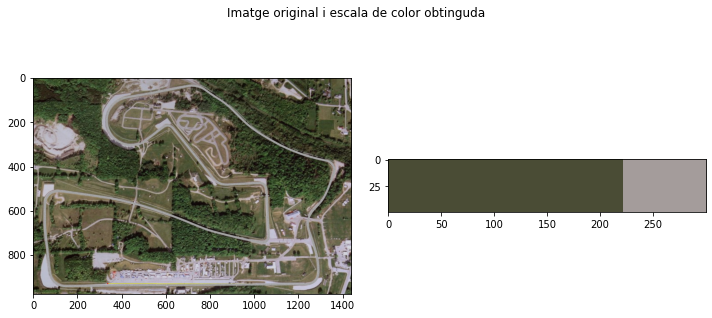

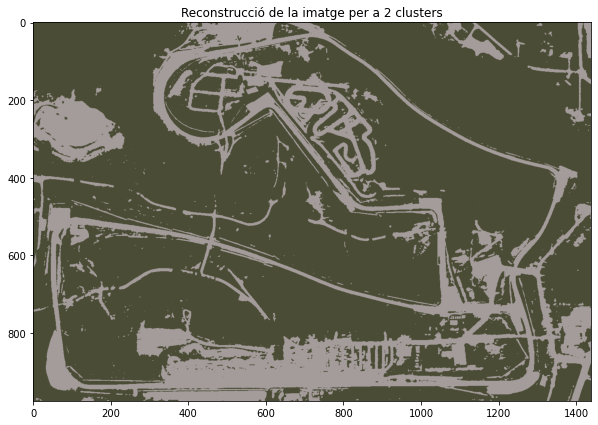

In [44]:
kmeans_color_representation(img, num_clusters=2)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> torna a aplicar-ho buscant 3 grups de píxels.
</div>

Image shape (1404464, 3)


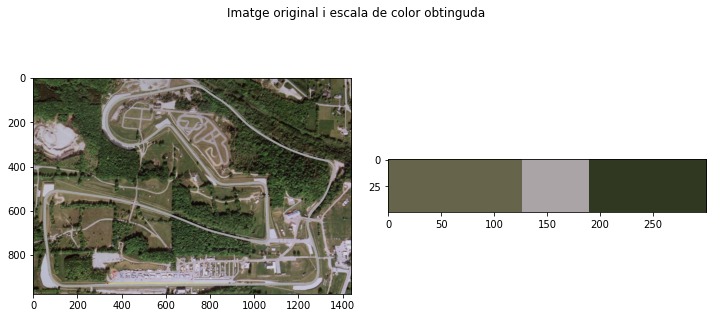

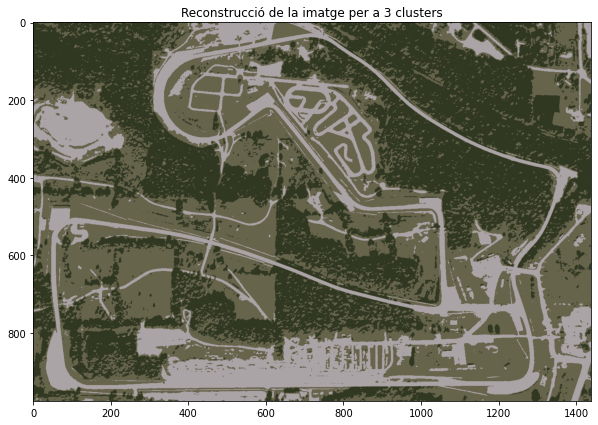

In [45]:
kmeans_color_representation(img, num_clusters=3)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Anàlisis:</strong> Quina regió representa cadascun d'ells?
</div>

El color gris representa les carreteres i zones urbanitzades. 
El color verd representa les zones boscoses i de vegetació. Finalment, el color beix
representa les zones amb terra.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> l'últim pas consisteix en aplicar el clustering i separar els camins del fons, posant aquest últim en negre (omplint amb 0 els valors dels píxels del fons). Així quedaran segmentats de forma automàtica els camins de la resta de la fotografia.
</div>